In [1]:
!pip install tensorflow==2.15.0 tf-keras ml-dtypes

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installa

In [2]:
import os
import shutil
from tqdm.auto import tqdm
import tensorflow as tf
from PIL import UnidentifiedImageError
from tensorflow.keras import layers, initializers, regularizers, constraints, activations,models
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import time
from tensorflow.keras.metrics import Precision, Recall, F1Score
print(tf.__version__)

2024-11-23 00:41:09.566029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 00:41:09.566143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 00:41:09.568351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:

class GroupConv2D(tf.keras.layers.Layer):
    def __init__(self, input_channels, output_channels, kernel_size, strides=(1, 1), padding='same', groups=32, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, **kwargs):
        super(GroupConv2D, self).__init__()
        self.groups = groups
        self.group_in_num = input_channels // groups
        self.group_out_num = output_channels // groups
        self.convs = [
            layers.Conv2D(filters=self.group_out_num, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=use_bias,
                          kernel_initializer=kernel_initializer, bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer, **kwargs)
            for _ in range(groups)
        ]

    def call(self, inputs):
        split_inputs = tf.split(inputs, self.groups, axis=-1)
        conv_outputs = [conv(split_inputs[i]) for i, conv in enumerate(self.convs)]
        return tf.concat(conv_outputs, axis=-1)


class ResNeXtBottleneck(layers.Layer):
    def __init__(self, filters, strides=1, groups=32, kernel_initializer='he_normal', **kwargs):
        super(ResNeXtBottleneck, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same', kernel_initializer=kernel_initializer)
        self.bn1 = layers.BatchNormalization()

        self.group_conv = GroupConv2D(input_channels=filters, output_channels=filters, kernel_size=3, strides=strides, padding='same', groups=groups, kernel_initializer=kernel_initializer)
        self.bn2 = layers.BatchNormalization()

        self.conv2 = layers.Conv2D(filters * 2, kernel_size=1, strides=1, padding='same', kernel_initializer=kernel_initializer)
        self.bn3 = layers.BatchNormalization()

        self.shortcut_conv = layers.Conv2D(filters * 2, kernel_size=1, strides=strides, padding='same', kernel_initializer=kernel_initializer)
        self.shortcut_bn = layers.BatchNormalization()

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)

        x = self.group_conv(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn3(x, training=training)

        shortcut = self.shortcut_conv(inputs)
        shortcut = self.shortcut_bn(shortcut, training=training)

        return tf.nn.relu(layers.add([x, shortcut]))

def build_resnext_block(filters, strides, groups, repeat_num, **kwargs):
    block = tf.keras.Sequential()
    block.add(ResNeXtBottleneck(filters=filters, strides=strides, groups=groups, **kwargs))
    for _ in range(1, repeat_num):
        block.add(ResNeXtBottleneck(filters=filters, strides=1, groups=groups, **kwargs))
    return block

class ResNeXt(tf.keras.Model):
    def __init__(self, repeat_num_list=[3, 4, 6, 3], cardinality=32, num_classes=2, num_landmarks=12, kernel_initializer='he_normal'):
        super(ResNeXt, self).__init__()
        self.conv1 = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_initializer=kernel_initializer)
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        self.block1 = build_resnext_block(128, 1, cardinality, repeat_num_list[0], kernel_initializer=kernel_initializer)
        self.block2 = build_resnext_block(256, 2, cardinality, repeat_num_list[1], kernel_initializer=kernel_initializer)
        self.block3 = build_resnext_block(512, 2, cardinality, repeat_num_list[2], kernel_initializer=kernel_initializer)
        self.block4 = build_resnext_block(1024, 2, cardinality, repeat_num_list[3], kernel_initializer=kernel_initializer)

        self.pool2 = layers.GlobalAveragePooling2D()

        self.classifier = layers.Dense(1, activation='sigmoid', name='output_classifier')
        self.regressor = layers.Dense(num_landmarks * 2, activation='linear', name='output_regressor')

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        x = self.block1(x, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.block4(x, training=training)

        x = self.pool2(x)
        classification_output = self.classifier(x)
        regression_output = self.regressor(x)

        return {'output_classifier': classification_output, 'output_regressor': regression_output}

model = ResNeXt()
model.build(input_shape=(None, 128, 128, 1))
model.summary()


Model: "res_ne_xt"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 32, 32, 256)       393984    
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 512)       2267136   
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 1024)        13

In [4]:

def parse_pts_and_label(filename):
    with open(filename) as file:
        lines = file.readlines()
        label = np.float32(int(lines[-1].split(': ')[1].strip())) 
        points_data = lines[3:-2] 
        points = [tuple(map(float, p.strip().split())) for p in points_data]
        points = np.array(points, dtype=np.float32)[36:48]  
    return points, label

def load_image_and_landmarks(filepath):
    image_path = filepath
    pts_path = filepath.replace('.jpg', '.pts') 

    image = Image.open(image_path)
    original_width, original_height = image.size
    image = image.resize((128, 128)).convert('L')  
    image = np.array(image, dtype=np.float32) / 255.0 
    image = np.expand_dims(image, axis=-1)

    points, label = parse_pts_and_label(pts_path)
    points[:, 0] /= original_width   
    points[:, 1] /= original_height 
    points = points.flatten() 

    return image, points, label

def load_data(directory):
    file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg')]
    images, points, labels = [], [], []
    count=0
    for filepath in file_paths:
        try:
            img, pts, label = load_image_and_landmarks(filepath)
            images.append(img)
            points.append(pts)
            labels.append(label)
            count+=1
            print(f"Procesando: {count} - {os.path.basename(filepath)}")
        except Exception as e:
            print(f"Error al procesar {filepath}: {str(e)}")

    return np.array(images), np.array(points), np.array(labels)

# Rutas de datos
train_dir = 'dataset-301/Dataset 30/train'
val_dir = 'dataset-301/Dataset 30/validation'
test_dir = 'dataset-301/Dataset 30/test 30'

# Cargar datos
train_images, train_points, train_labels = load_data(train_dir)
val_images, val_points, val_labels = load_data(val_dir)
test_images, test_points, test_labels = load_data(test_dir)


# Preparar datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, {'output_regressor': train_points, 'output_classifier': train_labels}))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, {'output_regressor': val_points, 'output_classifier': val_labels}))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, {'output_regressor': test_points, 'output_classifier': test_labels}))

Procesando: 1 - cr_n_g_image1447.jpg
Procesando: 2 - 031_000999.jpg
Procesando: 3 - 107635070_1-10.jpg
Procesando: 4 - 279_3_1.jpg
Procesando: 5 - en_n_g_image31.jpg
Procesando: 6 - indoor_051-20.jpg
Procesando: 7 - image_0612.jpg
Procesando: 8 - 408_000999.jpg
Procesando: 9 - 1269.jpg
Procesando: 10 - image_0264-20.jpg
Procesando: 11 - fe_n_g_image920.jpg
Procesando: 12 - 2652858910_1-30.jpg
Procesando: 13 - 10304.jpg
Procesando: 14 - 04423d195.jpg
Procesando: 15 - closed_eye_1836_1.jpg
Procesando: 16 - 11925.jpg
Procesando: 17 - 411_001036.jpg
Procesando: 18 - 090_4_2.jpg
Procesando: 19 - frame2_0176.jpg
Procesando: 20 - 04846d77.jpg
Procesando: 21 - 2330721439_1-20.jpg
Procesando: 22 - 10054.jpg
Procesando: 23 - closed_eye_2051_1.jpg
Procesando: 24 - 04311d231.jpg
Procesando: 25 - 04301d358.jpg
Procesando: 26 - en_d_b_image424.jpg
Procesando: 27 - 043_000446.jpg
Procesando: 28 - image_0755.jpg
Procesando: 29 - image_0193-10.jpg
Procesando: 30 - 13201.jpg
Procesando: 31 - 04854d153.j

In [5]:
size=8
train_dataset = train_dataset.shuffle(buffer_size=4048).batch(size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset= val_dataset.batch(size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(size).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:


initial_learning_rate = 0.005

optimizer = tf.keras.optimizers.AdamW(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss={
        'output_classifier': 'binary_crossentropy',
        'output_regressor': 'mean_squared_error'
    },
    loss_weights={
        'output_classifier': 0.4,  
        'output_regressor': 0.6
    },
    metrics={
        'output_classifier': [
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1_score', average='macro') 
        ],
        'output_regressor': [
            'mse', 
            tf.keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.RootMeanSquaredError(name='rmse')
        ]
    }
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,          
    patience=3,           
    verbose=1,            
    min_lr=0.00001        
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [ ]:


epochs =50 
start_time = time.time()
history = model.fit(
    train_dataset, 
    epochs=epochs,
    validation_data=val_dataset,  
    callbacks=[lr_scheduler, early_stopping_cb],
    verbose=1
)

# Evaluación del modelo en el conjunto de prueba
results = model.evaluate(test_dataset)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

end_time = time.time()
total_time = (end_time - start_time) / 60

print(f"El tiempo total de entrenamiento fue de {total_time:.2f} minutos.")

# Guardar el modelo
model.save('ResNeXt_50_Modelo_128x128_vf-31')
# Crear un convertidor para el modelo
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Convertir el modelo a TensorFlow Lite-
tflite_model = converter.convert()
# Guardar el modelo en formato TFLite
tflite_model_path = 'ResNeXt_50_Modelo_128x128-L_vf-31-TFL.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'Modelo convertido y guardado en {tflite_model_path}')


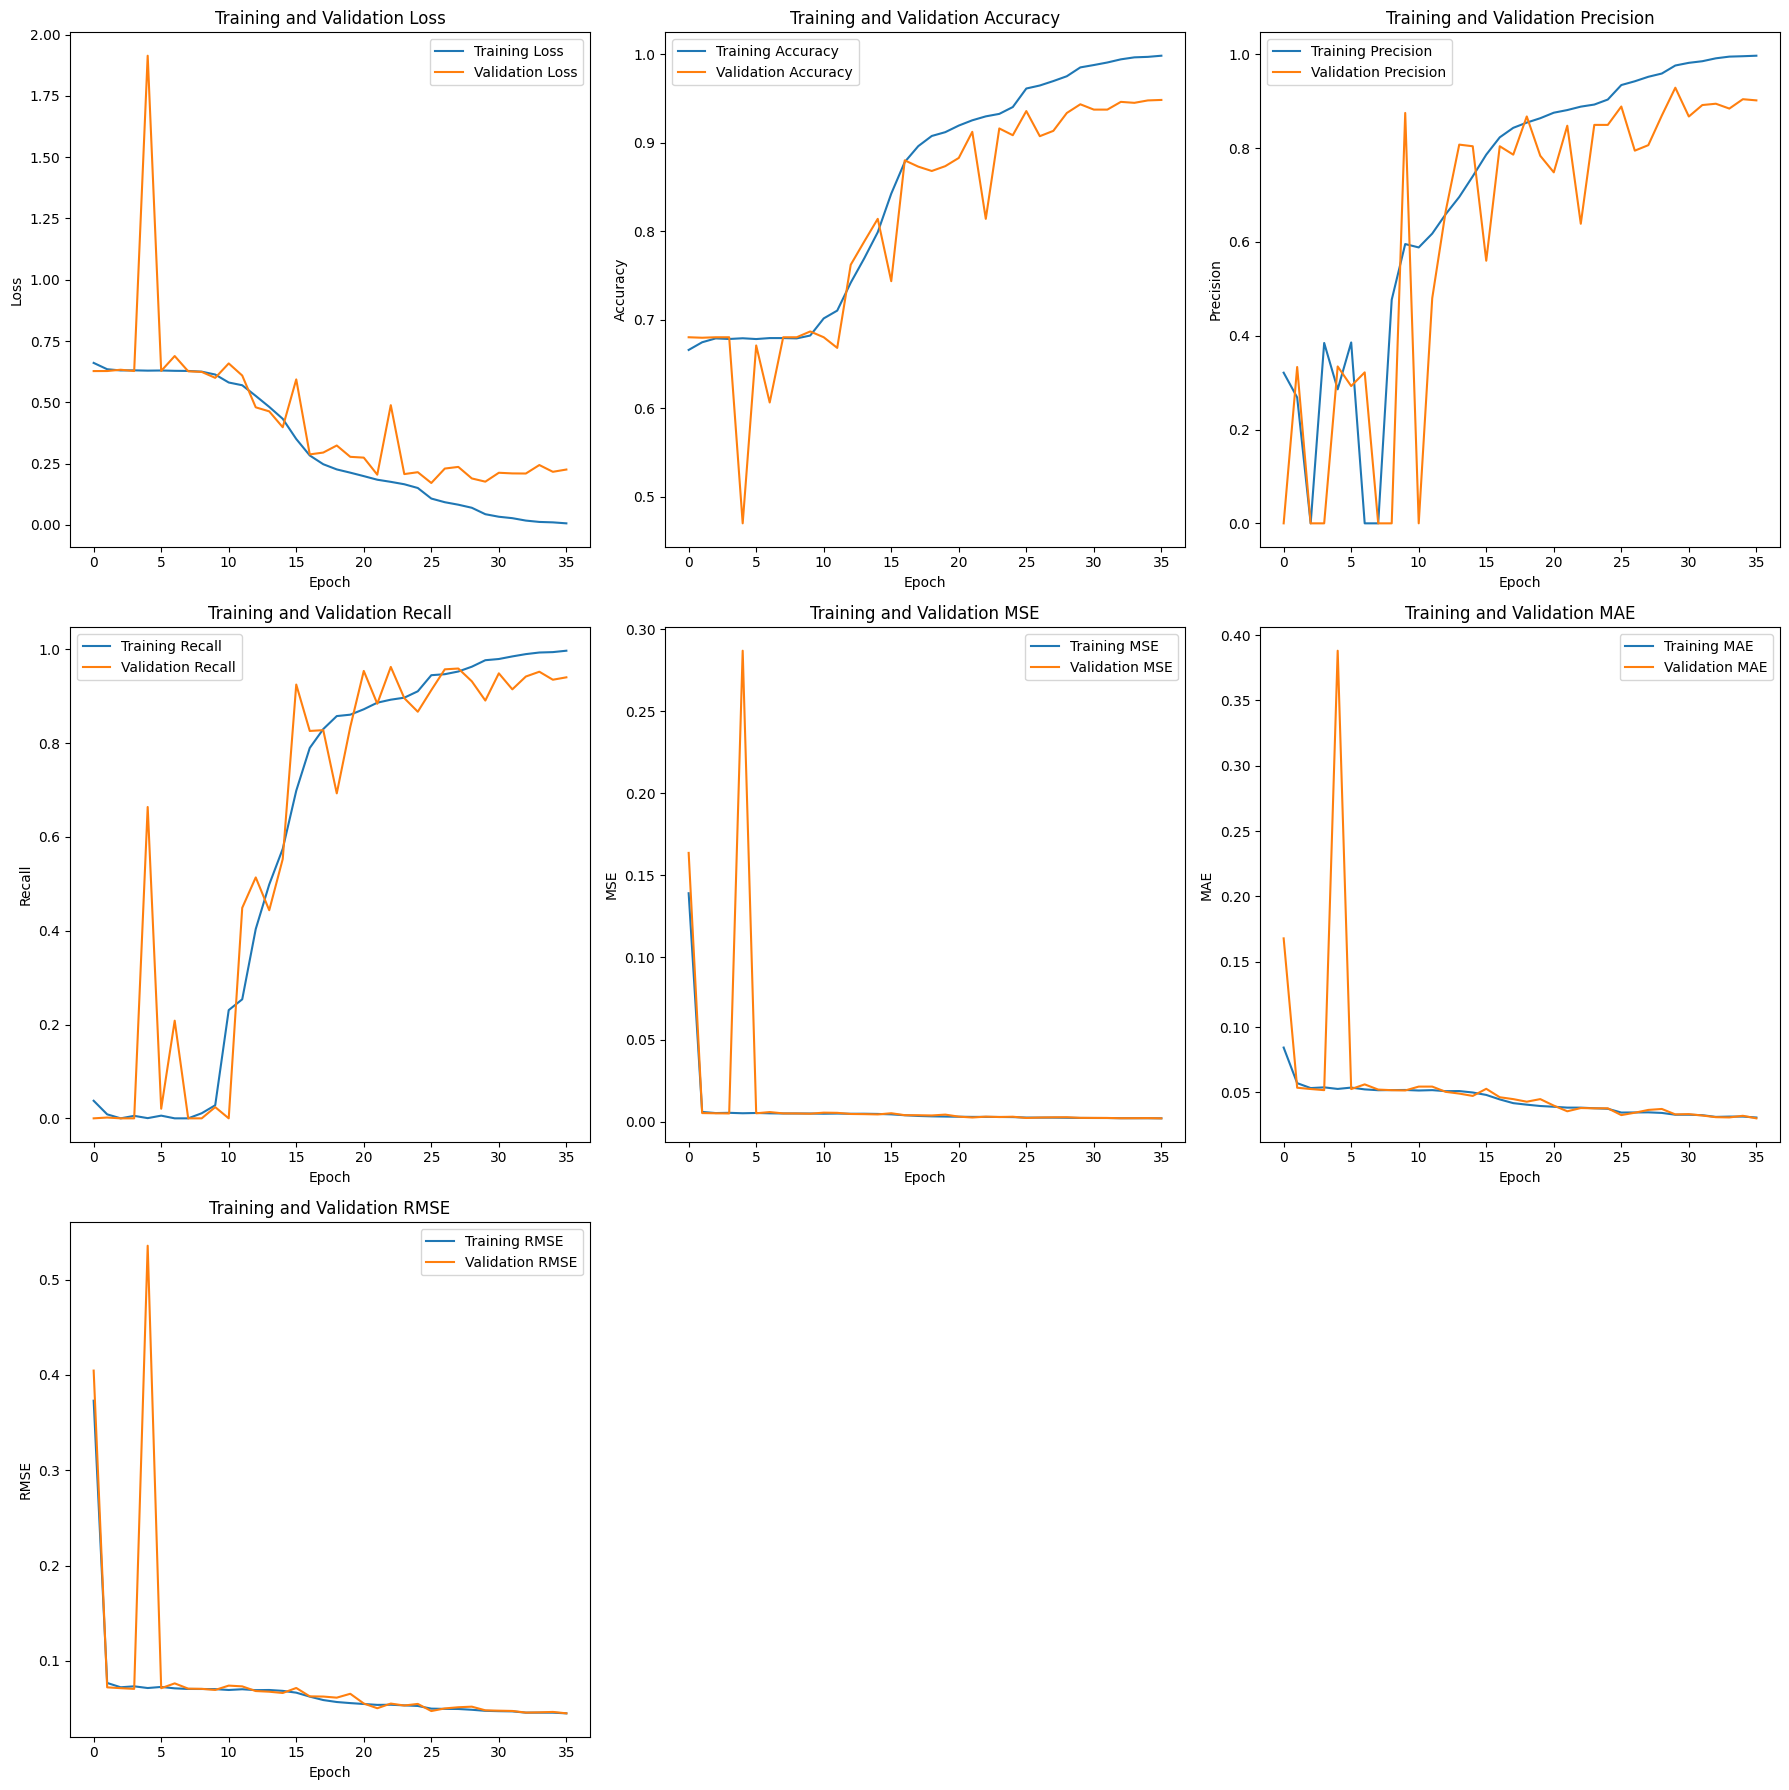

In [10]:


def plot_training_history(history):

    classifier_metrics = ['loss','accuracy', 'precision', 'recall']
    regressor_metrics = ['mse', 'mae', 'rmse']
    
    total_metrics = len(classifier_metrics) + len(regressor_metrics)
    rows = (total_metrics + 2) // 3 
    
    fig, axes = plt.subplots(rows, 3, figsize=(18, 6*rows))
    axes = axes.flatten() 
    
    for idx, metric in enumerate(classifier_metrics):
        metric_name = f'output_classifier_{metric}'
        axes[idx].plot(history.history[metric_name], label=f'Training {metric.title()}')
        axes[idx].plot(history.history[f'val_{metric_name}'], label=f'Validation {metric.title()}')
        axes[idx].set_title(f'Training and Validation {metric.title()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.title())
        axes[idx].legend()
    
    for idx, metric in enumerate(regressor_metrics):
        metric_name = f'output_regressor_{metric}'
        axes[idx + len(classifier_metrics)].plot(history.history[metric_name], 
                                               label=f'Training {metric.upper()}')
        axes[idx + len(classifier_metrics)].plot(history.history[f'val_{metric_name}'], 
                                               label=f'Validation {metric.upper()}')
        axes[idx + len(classifier_metrics)].set_title(f'Training and Validation {metric.upper()}')
        axes[idx + len(classifier_metrics)].set_xlabel('Epoch')
        axes[idx + len(classifier_metrics)].set_ylabel(metric.upper())
        axes[idx + len(classifier_metrics)].legend()
    

    for idx in range(total_metrics, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

plot_training_history(history)